In [1]:
import pandas as pd
import numpy as np
import os
import importlib
import matplotlib.pyplot as plt
from utilities import *
import utilities # functions for backtesting
from multiprocess import Pool

# Parameters & data

In [2]:
cost_buy=0.0001
cost_sell=0.0001
rate = 0.002 # use 0.002 as annualized risk free rate 

In [3]:
security = pd.read_csv('security_reference_data_w_ret1d.csv')
print(security.shape)
security.head()

(8800015, 7)


,data_date,security_id,close_price,volume,group_id,in_trading_universe,ret1d
0,20100104,77901,19.99,72728.0,20102010,N,0.025654
1,20100104,78001,23.77,460537.0,20101010,Y,0.034378
2,20100104,78401,19.64,1847102.0,20104020,Y,0.028272
3,20100104,82901,2.80,219545.0,20301010,N,0.060606
4,20100104,83501,7.90,389291.0,20201060,N,0.085165


In [4]:
security=security[security['volume']>0]
security['data_date'] = pd.to_datetime(security['data_date'], format='%Y%m%d')
security.shape

(8800014, 7)

In [5]:
close = security.pivot(columns='security_id', index='data_date',  values='close_price')
volume = security.pivot(columns='security_id', index='data_date',  values='volume')
ret1d = security.pivot(columns='security_id', index='data_date',  values='ret1d')
group_id = security.pivot(columns='security_id', index='data_date',  values='group_id')
in_trading_universe = security.pivot(columns='security_id', index='data_date',  values='in_trading_universe')

In [6]:
in_trading_universe=in_trading_universe.replace('N', np.nan)
in_trading_universe=in_trading_universe.replace('Y', 1.0)
in_trading_universe.head()

security_id,1031,1631,77901,78001,78401,82901,83501,83801,83901,85001,...,1117931301,1117946401,1117962801,1117971901,1117980001,1117990501,1117990901,1117992101,1117995601,1118042001
data_date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
group_id=group_id//1000000 # only select L1 industry
groups = np.unique(security['group_id'].unique()//1000000)
industry = pd.DataFrame()
for g in groups:
    df = group_id*np.nan
    df[group_id==g]=1
    industry = pd.concat([industry, df])#[g] = df

In [8]:
group_id.head()

security_id,1031,1631,77901,78001,78401,82901,83501,83801,83901,85001,...,1117931301,1117946401,1117962801,1117971901,1117980001,1117990501,1117990901,1117992101,1117995601,1118042001
data_date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,20.0,20.0,20.0,20.0,20.0,40.0,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,20.0,20.0,20.0,20.0,20.0,40.0,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,20.0,20.0,20.0,20.0,20.0,40.0,25.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,20.0,20.0,20.0,20.0,20.0,40.0,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,20.0,20.0,20.0,20.0,20.0,40.0,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
columns = close.columns
dates = close.index
# dates_pre = dates[(dates<'2012-01-01')]
dates_in = dates[(dates>='2012-01-01') & (dates<'2016-01-01')]
dates_post = dates[(dates>='2016-01-01')]
dates_in = dates[(dates<'2016-01-01')]

weeks = close.groupby([close.index.year, close.index.isocalendar().week]).tail(1).index
weeks_pre = weeks[(weeks<'2012-01-01')]
weeks_in = weeks[(weeks>='2012-01-01') & (weeks<'2016-01-01')]
weeks_post = weeks[(weeks>='2016-01-01')]
# weeks_in = weeks[(weeks<'2016-01-01')]

# Risk factor

In [10]:
risk = pd.read_csv('risk_factors.csv')
risk['data_date'] = pd.to_datetime(risk['data_date'], format='%Y%m%d')
risk.head()

,data_date,security_id,rf1,rf2,rf3,rf4,rf5,rf6
0,2010-01-04,5311701,0.284,-0.500,1.789,2.962,-0.435,-0.314
1,2010-01-04,3780701,1.890,-1.330,-0.208,0.775,-0.803,-0.576
2,2010-01-04,2297301,0.012,0.217,0.285,-0.151,0.883,0.127
3,2010-01-04,83501,1.185,1.195,2.677,-1.485,-1.236,-1.341
4,2010-01-04,4159901,-0.335,-2.917,2.548,1.691,0.394,-2.290


In [11]:
risk_factors = {}
    
for k in risk.columns[2:]:
    df_pivot = risk.pivot(columns='security_id', index='data_date', values=k)
    df_pivot = df_pivot.reindex(columns=columns, index=dates)
    df_pivot = df_pivot * in_trading_universe
    df_pivot = df_pivot.sub(df_pivot.mean(axis=1), axis=0) # de-mean
#     for i in risk_factors.keys():
#         df_pivot = orthogonal(df_pivot, risk_factors[i]) # Gram-Schmidt
    risk_factors[k] = df_pivot

In [12]:
risk_factors.keys()

dict_keys(['rf1', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6'])

# Factors

## Generate factors

In [13]:
gp1 = ['data_set_1', 'data_set_2']
gp2 = ['data_set_3', 'data_set_4', 'data_set_5', 'data_set_6', 'data_set_7']
gp3 = ['data_set_8', 'data_set_9']
gp4 = ['data_set_10', 'data_set_11'] #

In [14]:
path_of_the_directory= 'data_sets'
factors = {}
for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory, filename)
    if os.path.isfile(f):
        k = filename.split('.')[0]
        df = pd.read_csv(f)
        df = df.drop_duplicates(subset=df.columns[:-1]) # TODO check why
        df_pivot = df.pivot(columns='security_id', index='data_date', values=df.columns[-1])
        df_pivot.index = pd.to_datetime(df_pivot.index, format='%Y%m%d')
        df_pivot = df_pivot.reindex(columns=columns, index=dates)
        df_pivot = df_pivot.clip(lower=df_pivot.quantile(0.01), upper=df_pivot.quantile(0.99), axis=1) 
        # Winsorize
        if k in gp1+gp2:
            df_pivot = df_pivot.ffill(limit=int(80)) # ffill 4 months
        df_pivot = df_pivot * in_trading_universe # select stock universe
        df_pivot = df_pivot.sub(df_pivot.mean(axis=1), axis=0) # de-mean
        factors[k] = df_pivot

In [15]:
factors.keys()

dict_keys(['data_set_5', 'data_set_4', 'data_set_6', 'data_set_7', 'data_set_3', 'data_set_2', 'data_set_1', 'data_set_11', 'data_set_9', 'data_set_8', 'data_set_10'])

<AxesSubplot:xlabel='data_date'>

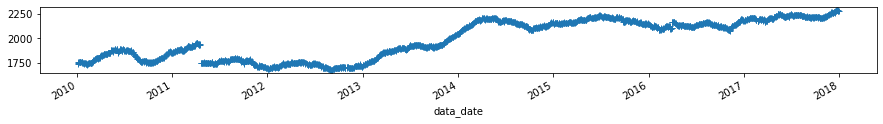

In [16]:
in_trading_universe.count(1).plot(kind = 'line', legend=False, figsize = (15,1.36), ls="none", marker="+")

array([<AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>], dtype=object)

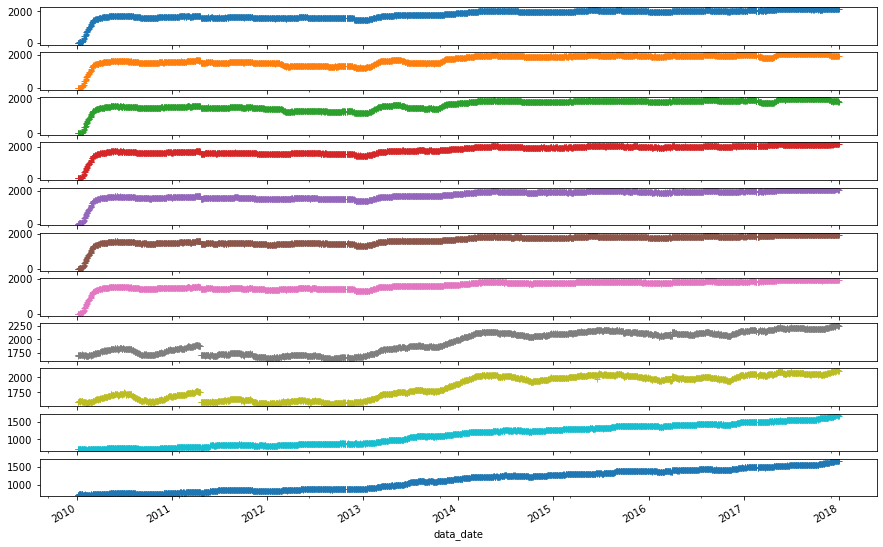

In [17]:
df_count = pd.DataFrame()

for k in factors.keys():
    factor = factors[k]
    df_count[k] = factor.count(1)
    
df_count.reset_index().plot(x="data_date", y=gp1+gp2+gp3+gp4, kind = 'line', legend=False, 
                 subplots = True, sharex = True, sharey = False, figsize = (15,10), ls="none", marker="+")

array([<AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>, <AxesSubplot:xlabel='data_date'>,
       <AxesSubplot:xlabel='data_date'>], dtype=object)

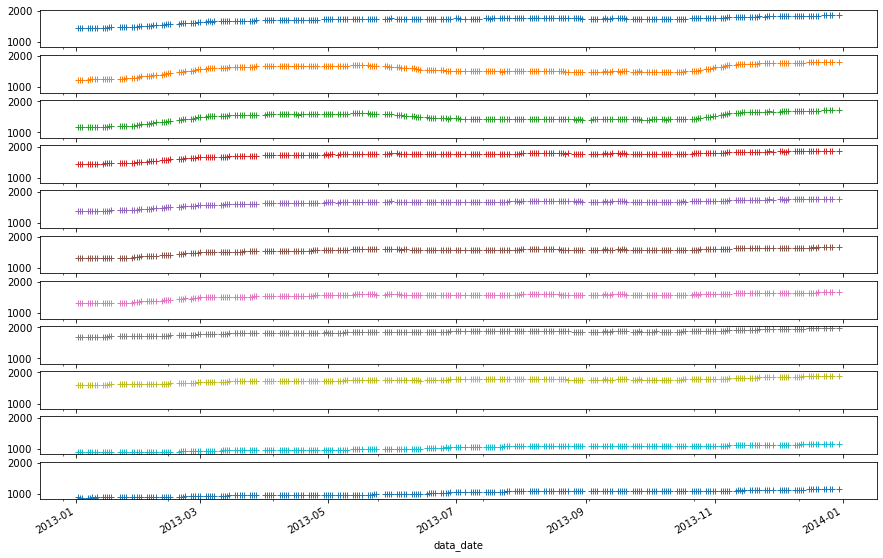

In [18]:
df_count0 = df_count[(df_count.index < '2013-12-31') & (df_count.index > '2012-12-31')]
df_count0.reset_index().plot(x="data_date", y=gp1+gp2+gp3+gp4, kind = 'line', legend=False, 
                 subplots = True, sharex = True, sharey = True, figsize = (15,10), ls="none", marker="+")

## Neutralize risk factors

In [19]:
# ['rf1', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6']
# i = 'rf5'
# for k in factors.keys():
# #     for i in risk_factors.keys():
#     factor = factors[k]
#     factor = orthogonal(factor, risk_factors[i][~factors[k].isna()]) # orthogonalize
#     factors[k] = factor

In [20]:
# for p in [('data_set_2', 'rf1'),
#          ('data_set_6', 'rf3'),
#          ('data_set_3', 'rf5'),
#          ('data_set_9', 'rf4'),
#          ('data_set_10', 'rf1')]:
#     factor = factors[p[0]]
#     factor = orthogonal(factor, risk_factors[p[1]][~factor.isna()]) # orthogonalize
#     factors[p[0]] = factor

In [21]:
# for p in [('data_set_6', 'rf2'),
#          ('data_set_9', 'rf5')]:
#     factor = factors[p[0]]
#     factor = orthogonal(factor, risk_factors[p[1]][~factor.isna()]) # orthogonalize
#     factors[p[0]] = factor

# risk_factors[j] = orthogonal(risk_factors[j], risk_factors[i]) # Gram-Schmidt

## Backtest raw factors

In [22]:
factor_models= {}

num_ranks12 = 30
num_ranks3 = 40
num_ranks4 = 30
nrows = len(gp1+gp2+gp3+gp4)

In [23]:
for k in gp1+gp2+gp3+gp4: 
    factor = factors[k]
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better
    if k in gp1+gp2: # low frequency
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks12))
    elif k in gp3:
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks3))
    else:
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks4))
    factor.fillna(9999, inplace=True) # not in factor
    factor = factor * in_trading_universe # select stock universe
#     factor.fillna(19999, inplace=True) # not tradable
    factor_models[k] = factor

In [24]:
importlib.reload(utilities)

keys = list(factor_models.keys())
l = [factor_models[k] for k in keys]
n = len(keys)
with Pool() as p:
    res=p.starmap(utilities.quick_backtesting, zip(keys, l, [ret1d]*n)) # no trading cost
    
longs = {x['name']: x['long_pnl'] for x in res}
counts = {x['name']: x['counts'] for x in res}
turnovers = {x['name']: x['turnover'] for x in res}

In [25]:
longs.keys()

dict_keys(['data_set_1', 'data_set_2', 'data_set_3', 'data_set_4', 'data_set_5', 'data_set_6', 'data_set_7', 'data_set_8', 'data_set_9', 'data_set_10', 'data_set_11'])

In [26]:
weekly_long = {}
weekly_turnover = {}
for k in longs.keys():
    weekly_long[k] = longs[k].groupby([longs[k].index.year, 
                                       longs[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')
    weekly_turnover[k] = turnovers[k].groupby([turnovers[k].index.year, 
                                       turnovers[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')

### In-sample counts 

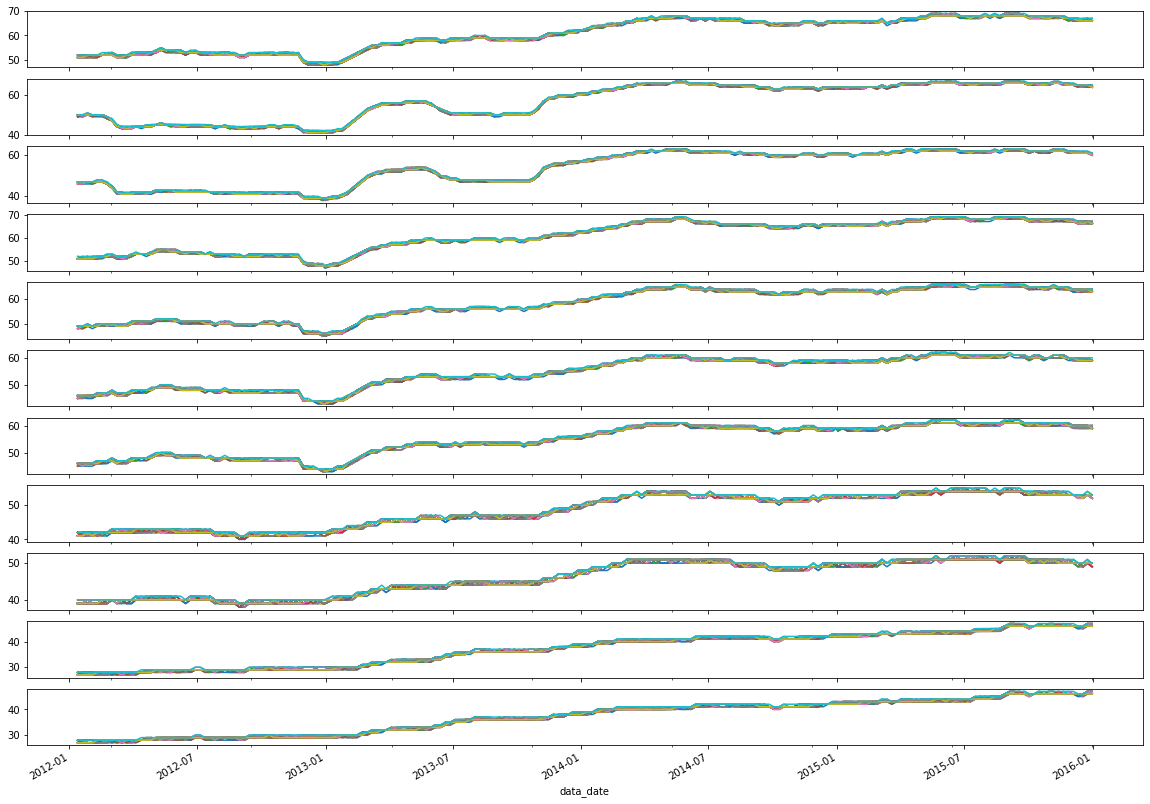

In [27]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,15), sharex=True, sharey=False)
i = 0
for k in counts.keys():
    counts[k].loc[weeks_in].iloc[:,:-1].plot(ax=axes[i], legend=False)
    i += 1

data_set_1 161.0 57.176431424766974
data_set_2 212.0 54.01797603195739
data_set_3 322.0 51.06066666666667
data_set_4 155.0 57.39880159786951
data_set_5 242.0 54.830892143808256
data_set_6 373.0 51.40878828229028
data_set_7 365.0 51.53528628495339
data_set_8 35.0 46.39761431411531
data_set_9 150.0 43.81709741550696
data_set_10 759.0 32.84691848906561
data_set_11 759.0 32.84691848906561


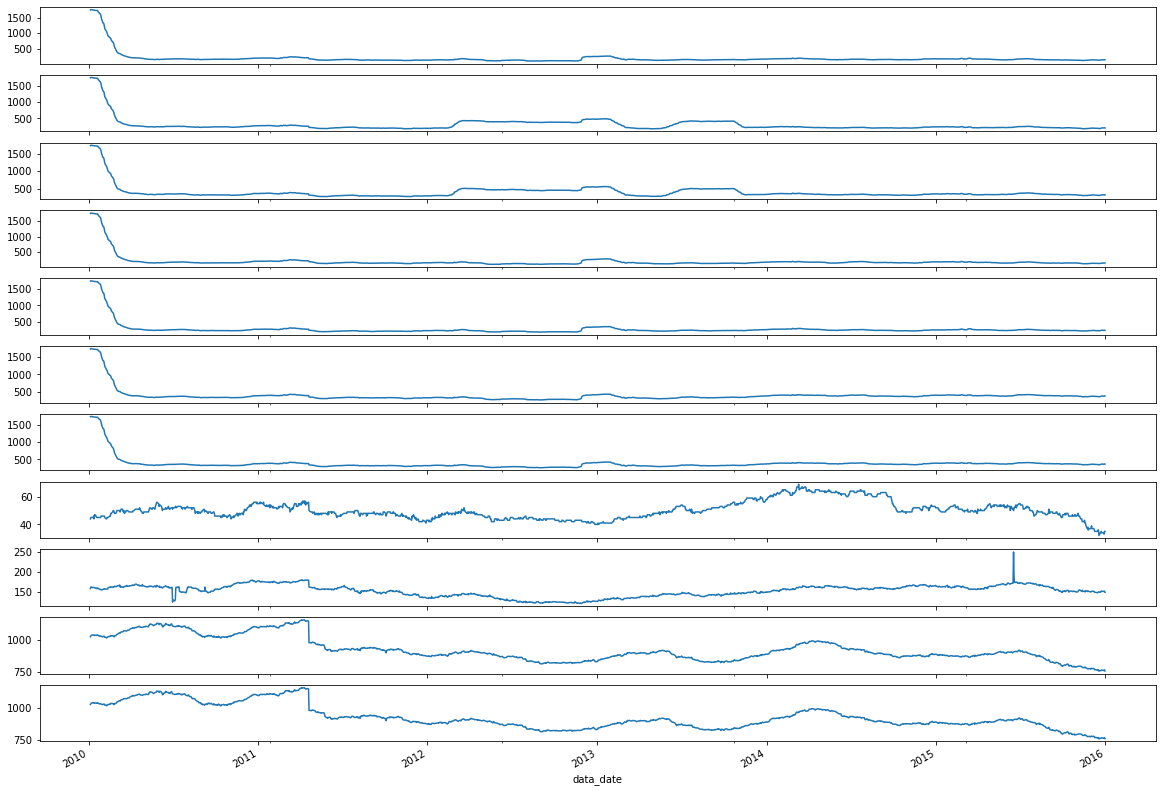

In [28]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,15), sharex=True, sharey=False)
i = 0
for k in counts.keys():
    print(k, counts[k].loc[dates_in, 9999][-1], counts[k].loc[dates_in, 1][dates_in].mean())
    counts[k].loc[dates_in, 9999].plot(ax=axes[i], legend=False)
    i += 1

### In-sample turnovers

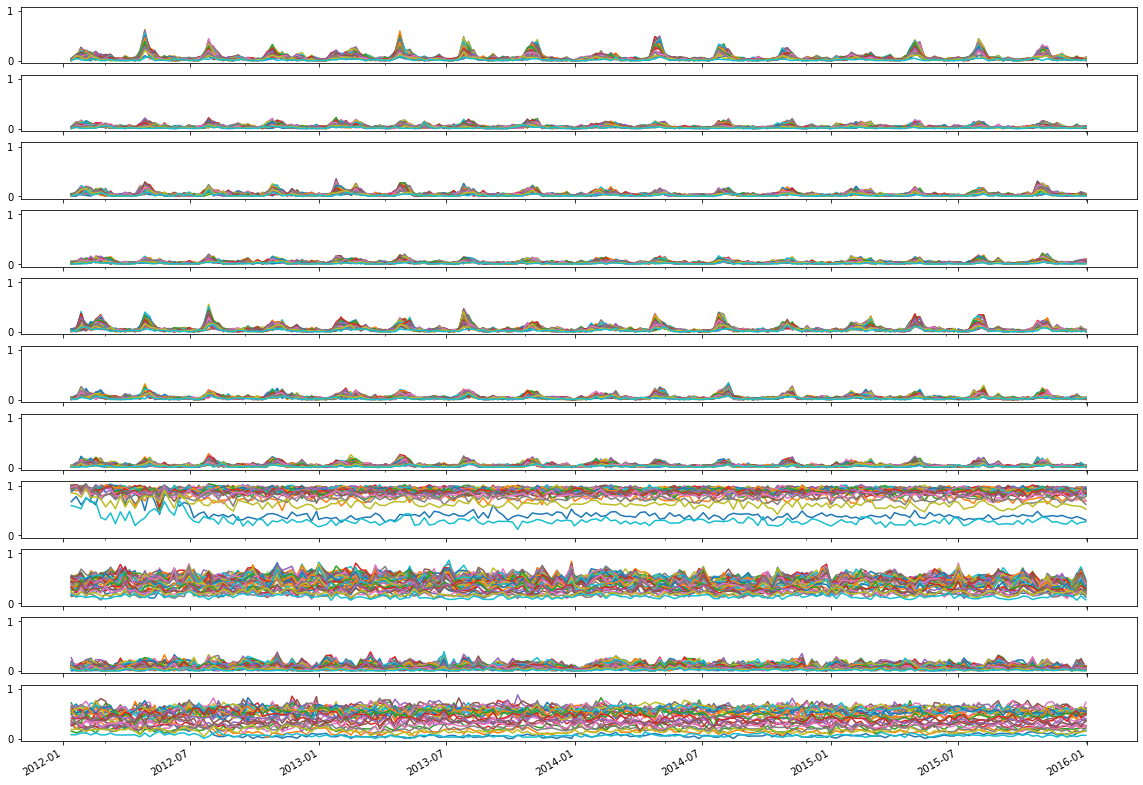

In [29]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,15), sharex=True, sharey=True)
i = 0
for k in turnovers.keys():
    turnovers[k].loc[weeks_in].iloc[:,:-1].plot(ax=axes[i], legend=False)
    i += 1

### In-sample pnls -- mean

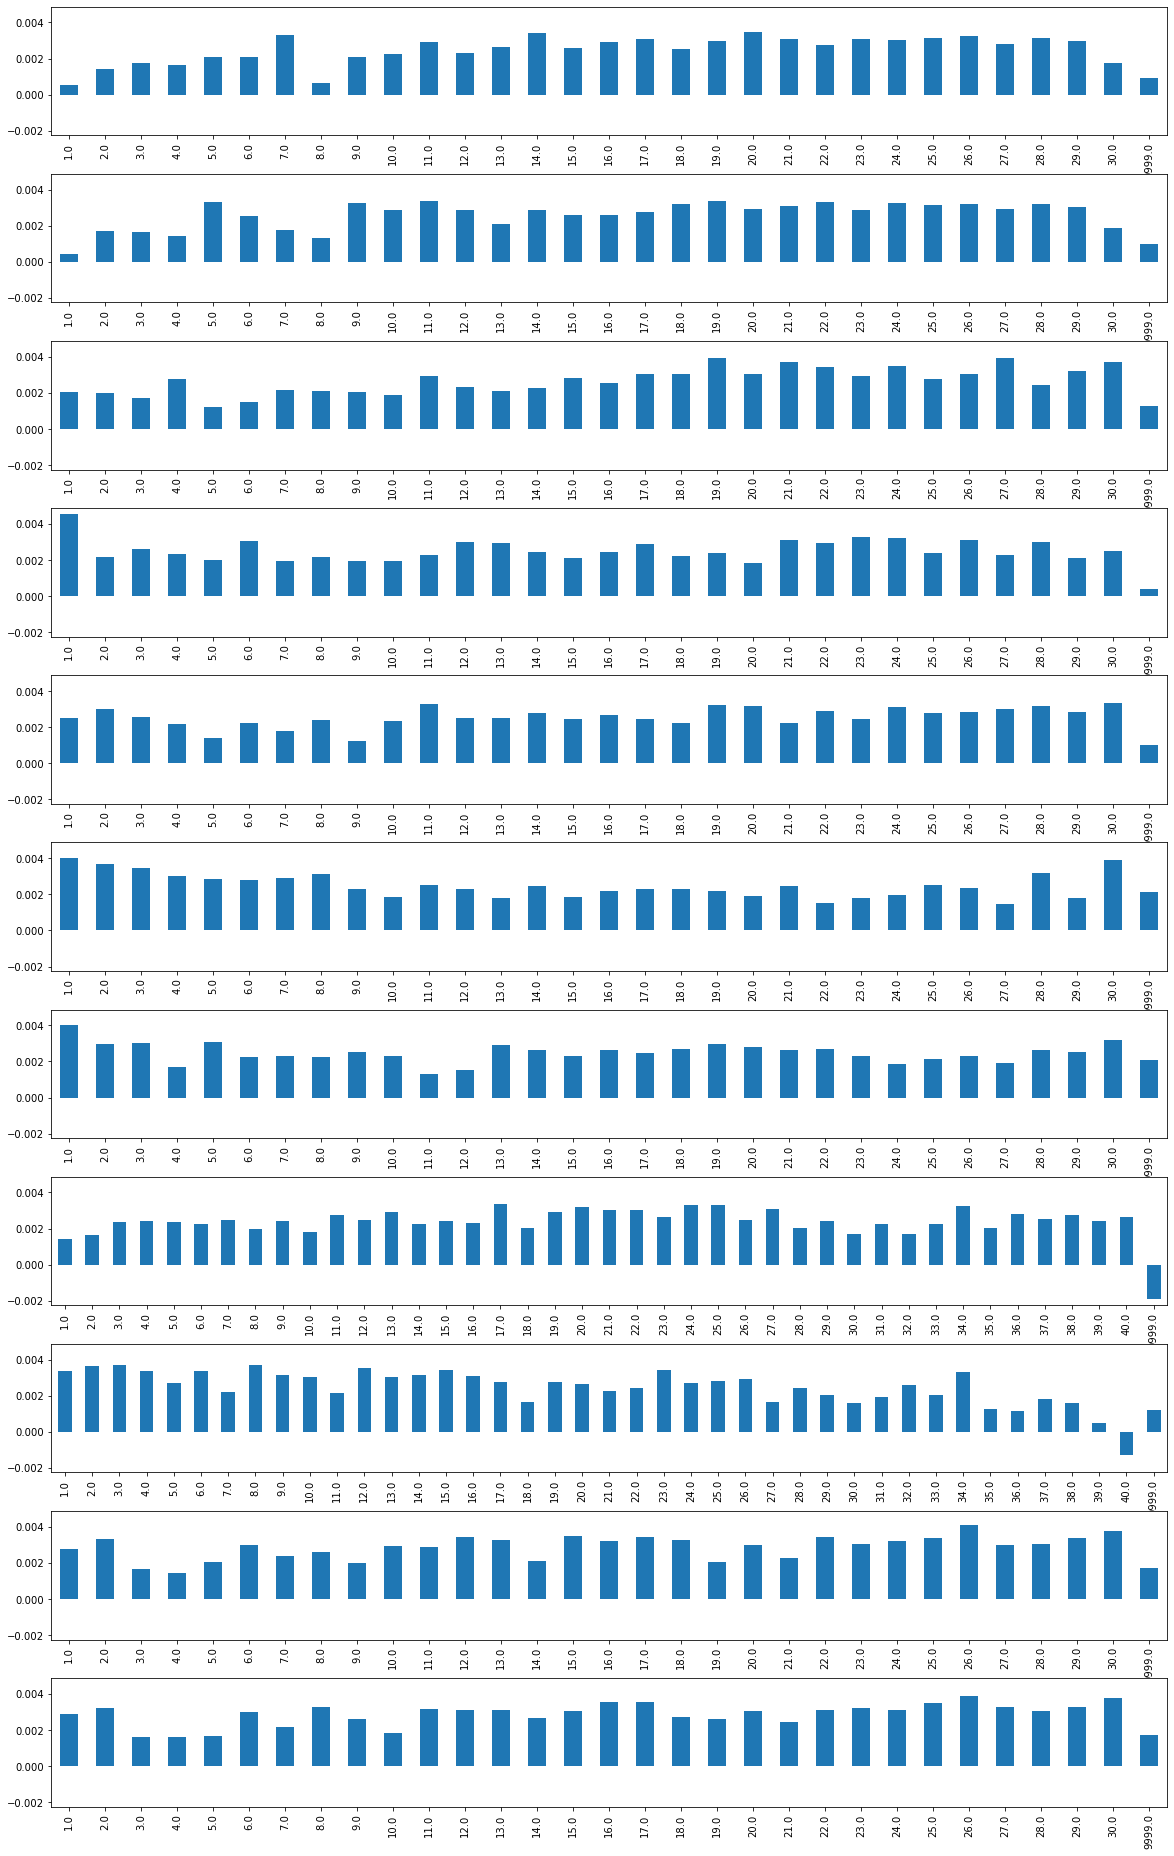

In [30]:
nrows = len(weekly_long.keys())
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,25), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)
i = 0
for k in weekly_long.keys():
    weekly_long[k].loc[weeks_in].mean().plot.bar(ax=axes[i])
    i += 1

### In-sample pnls -- std

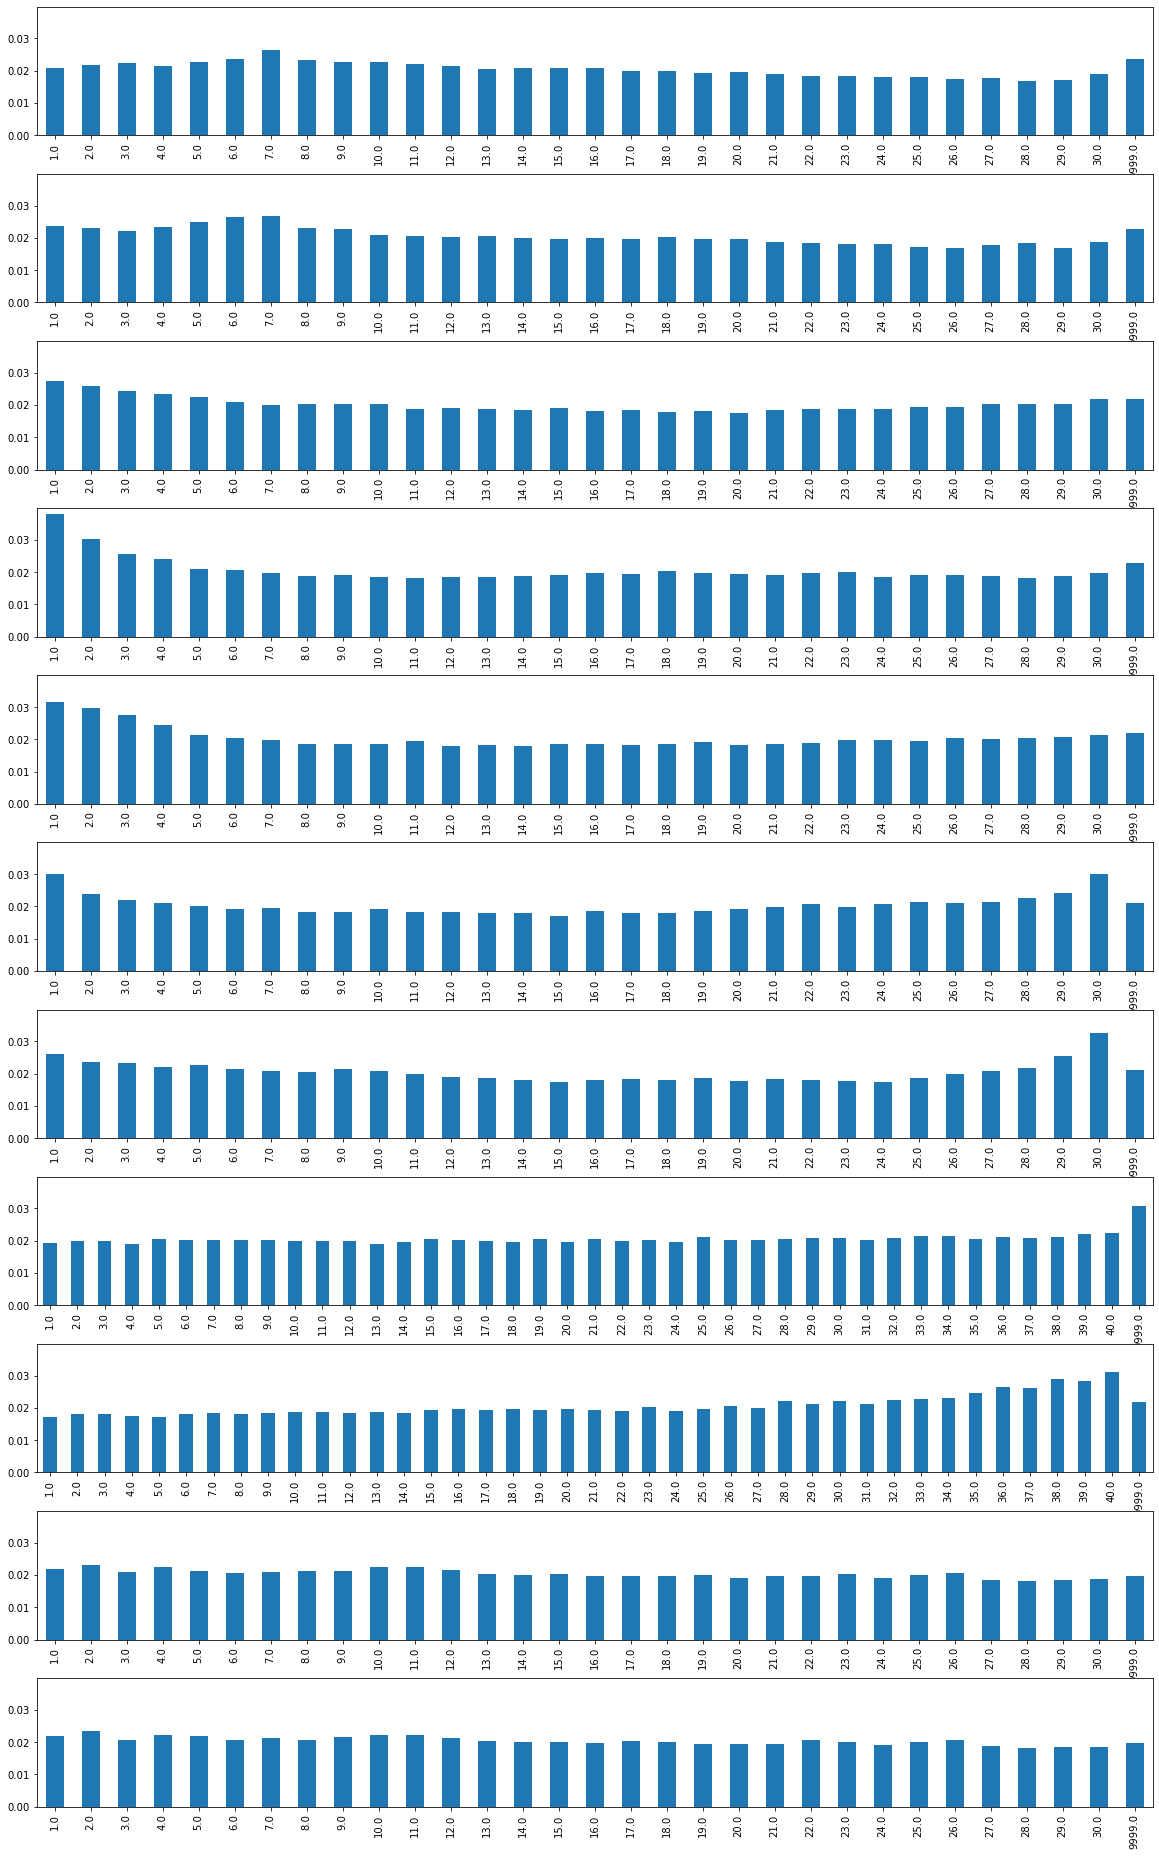

In [31]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,25), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)

i = 0
for k in weekly_long.keys():
    weekly_long[k].loc[weeks_in].std().plot.bar(ax=axes[i])
    i += 1

### In-sample pnls -- sharp

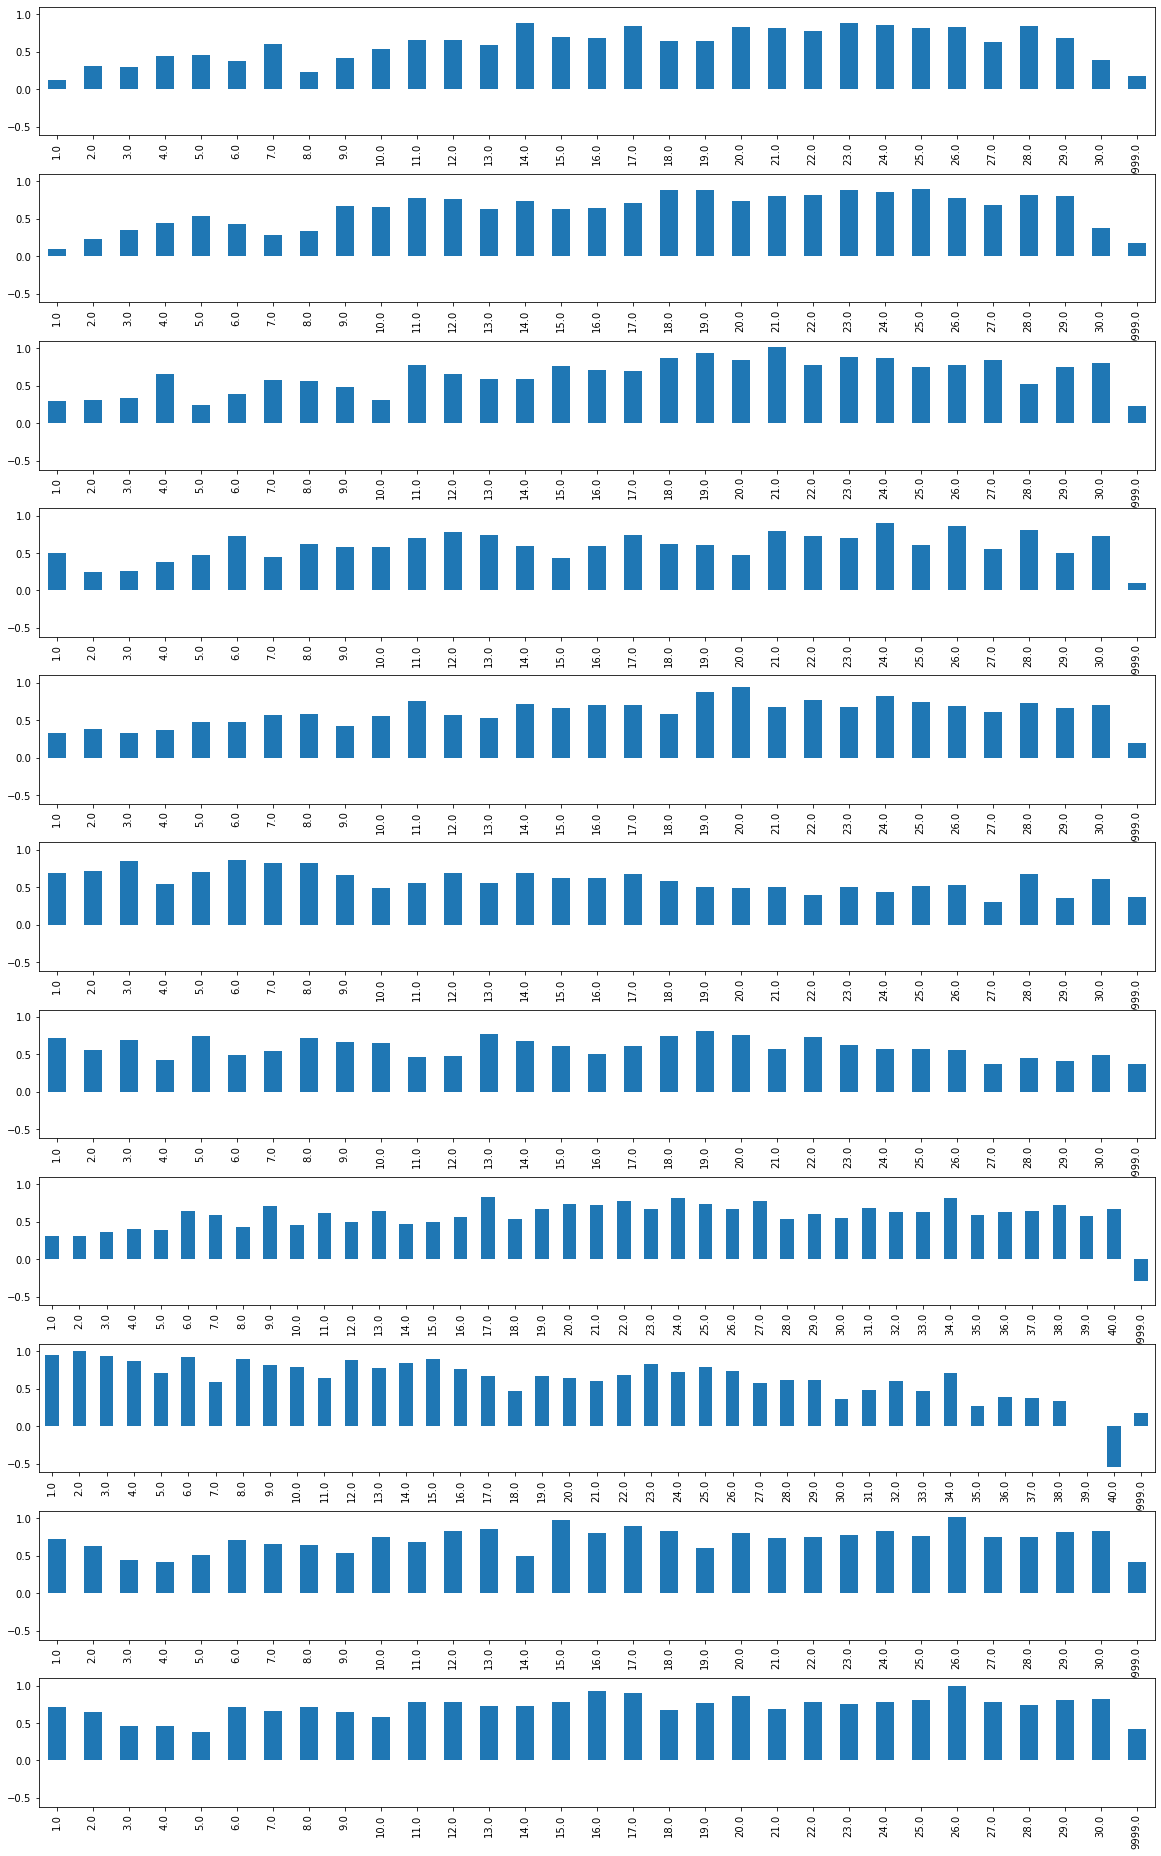

In [32]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,25), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)

i = 0
for k in longs.keys():
    (longs[k].loc[dates_in].mean()/longs[k].loc[dates_in].std()*np.sqrt(252)).plot.bar(ax=axes[i])
    i += 1

## Combine factors

### layer 1 -- gp1 + gp2

In [33]:
longs_l1 = {}
shorts_l1 = {}
counts_l1 = {}
turnovers_l1 = {}
factor_models_l1= {}

num_ranks12 = 6

In [34]:
for k in gp1+gp2: 
    factor = factors[k]
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better
    factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks12))
    factor.fillna(9999, inplace=True) # not in factor
    factor = factor * in_trading_universe # select stock universe
#     factor.fillna(19999, inplace=True) # not tradable
    factor_models_l1[k] = factor

In [35]:
importlib.reload(utilities)

l = [factor_models_l1[k] for k in gp1+gp2]
nrows = len(gp1+gp2)
with Pool() as p:
    res=p.starmap(utilities.quick_backtesting, zip(gp1+gp2, l, [ret1d]*nrows)) # 0 trading cost
    
longs_l1 = {x['name']: x['long_pnl'] for x in res}
counts_l1 = {x['name']: x['counts'] for x in res}
turnovers_l1 = {x['name']: x['turnover'] for x in res}

In [36]:
weekly_long_l1 = {}
weekly_turnover_l1 = {}
for k in longs_l1.keys():
    weekly_long_l1[k] = longs_l1[k].groupby([longs_l1[k].index.year, 
                                       longs_l1[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')
    weekly_turnover_l1[k] = turnovers_l1[k].groupby([turnovers_l1[k].index.year, 
                                       turnovers_l1[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')


#### corr between factors

<AxesSubplot:>

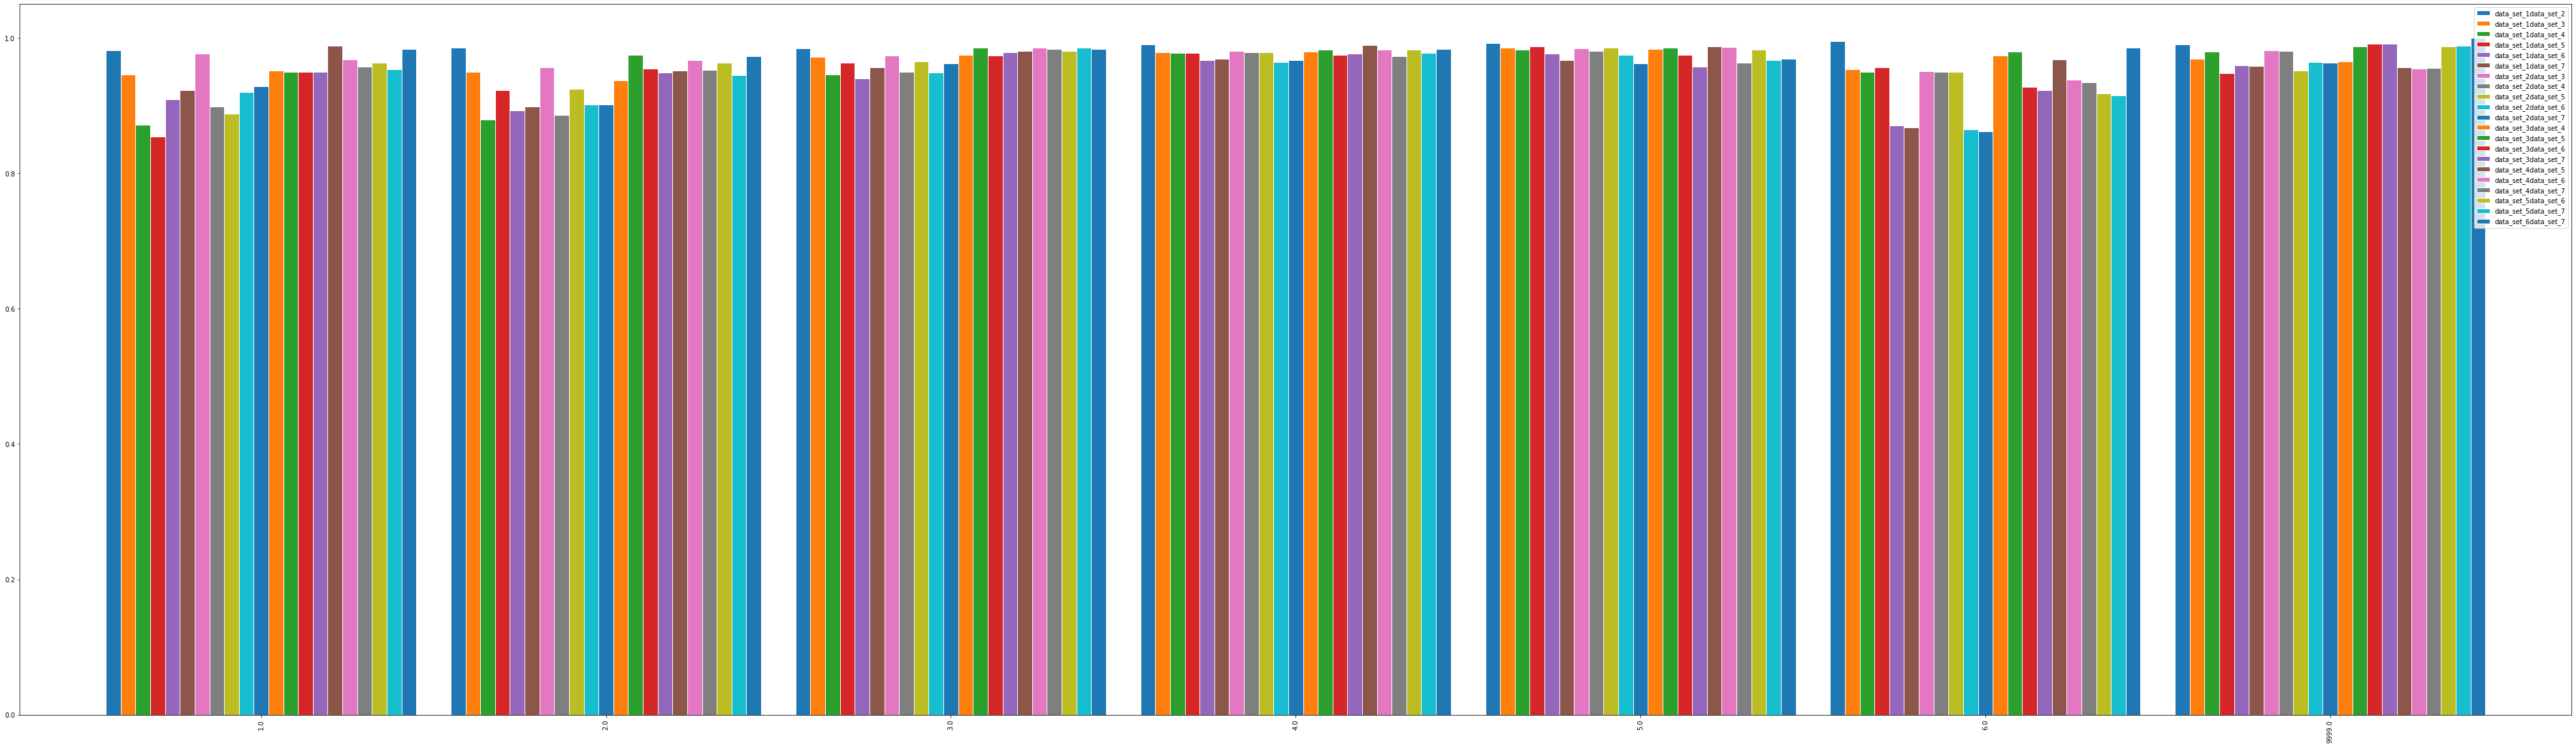

In [37]:
df=pd.DataFrame()
for j in gp1+gp2:
    for k in gp1+gp2:
        if j < k:
            df[j+k] = weekly_long_l1[j].loc[weeks_in].corrwith(weekly_long_l1[k].loc[weeks_in], axis=0)

df.plot(kind='bar', edgecolor='white', linewidth=1, figsize=(70,20), width=.9)
# plt.savefig('factor_corrs_L1.pdf', dpi=1000)

#### counts -- mean

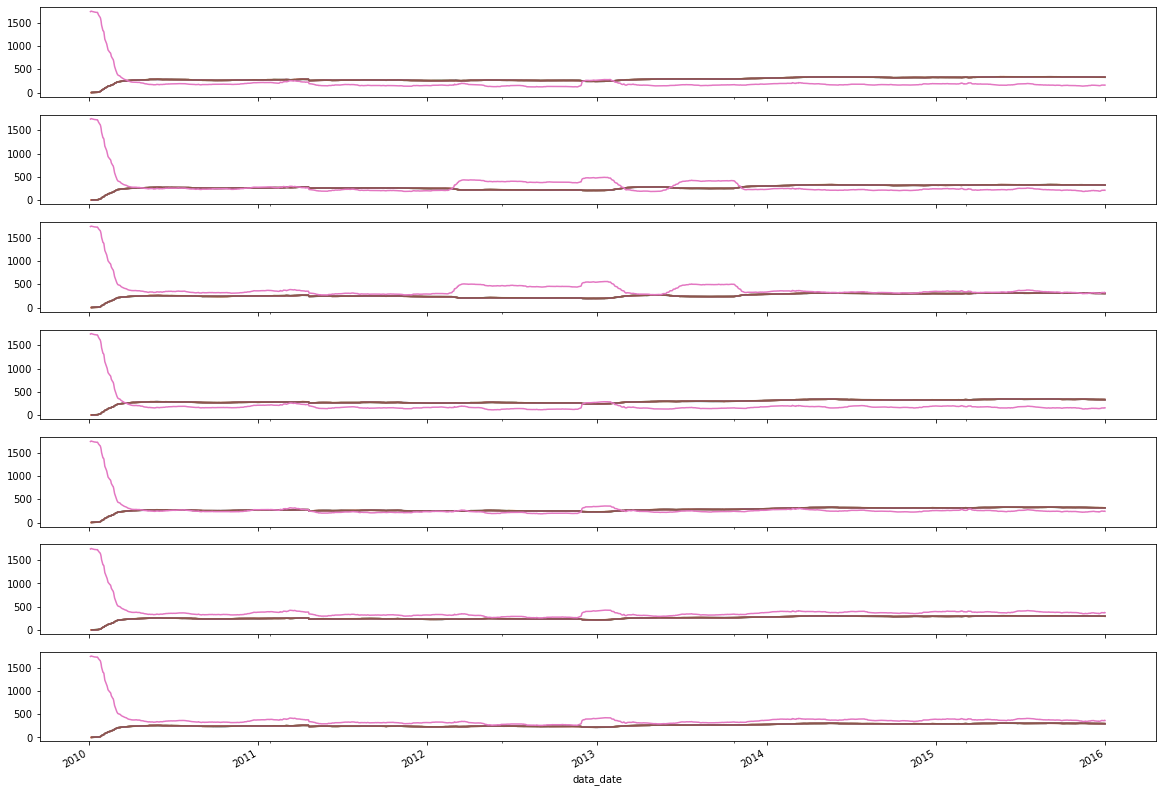

In [38]:
nrows = len(gp1+gp2)
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,15), sharex=True, sharey=True)
i = 0
for k in gp1+gp2:
    counts_l1[k].loc[dates_in].plot(ax=axes[i], legend=False)
    i += 1

#### Presample pnls -- mean

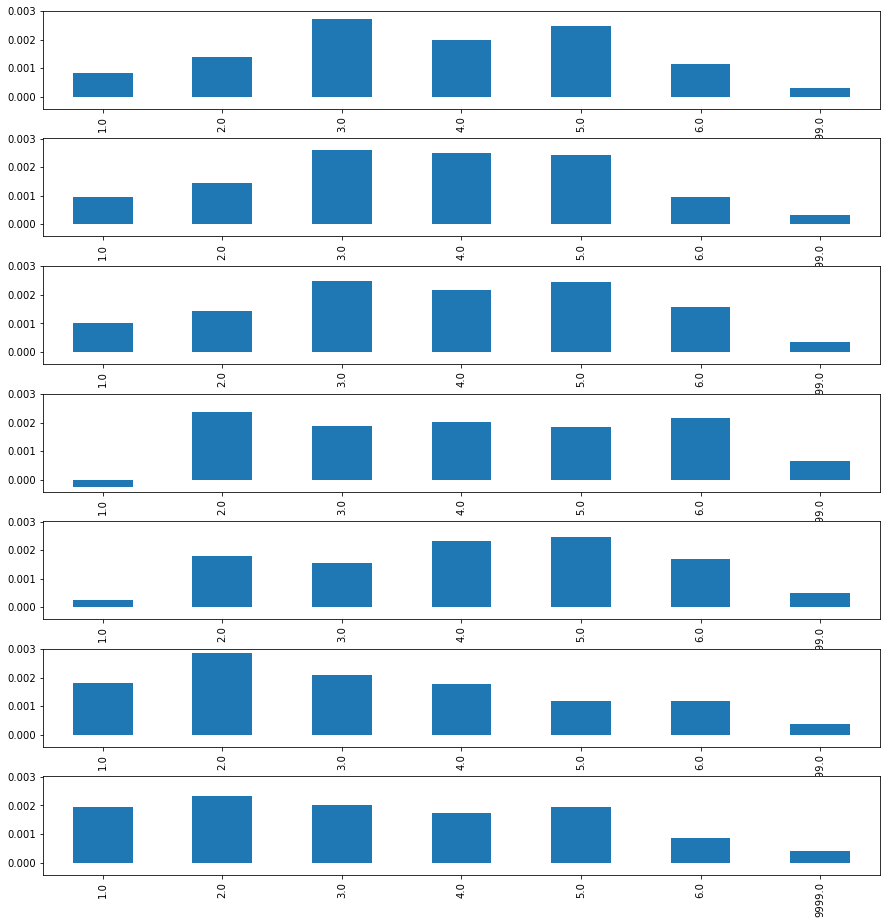

In [39]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15,8), sharey=True)
plt.subplots_adjust(top = 1.5, bottom=0.0, hspace=0.3)
i = 0
for k in gp1+gp2:
#     print(k)
    weekly_long_l1[k].loc[weeks_pre].iloc[:,:].mean().plot.bar(ax=axes[i])
    i += 1

#### Insample pnls -- mean

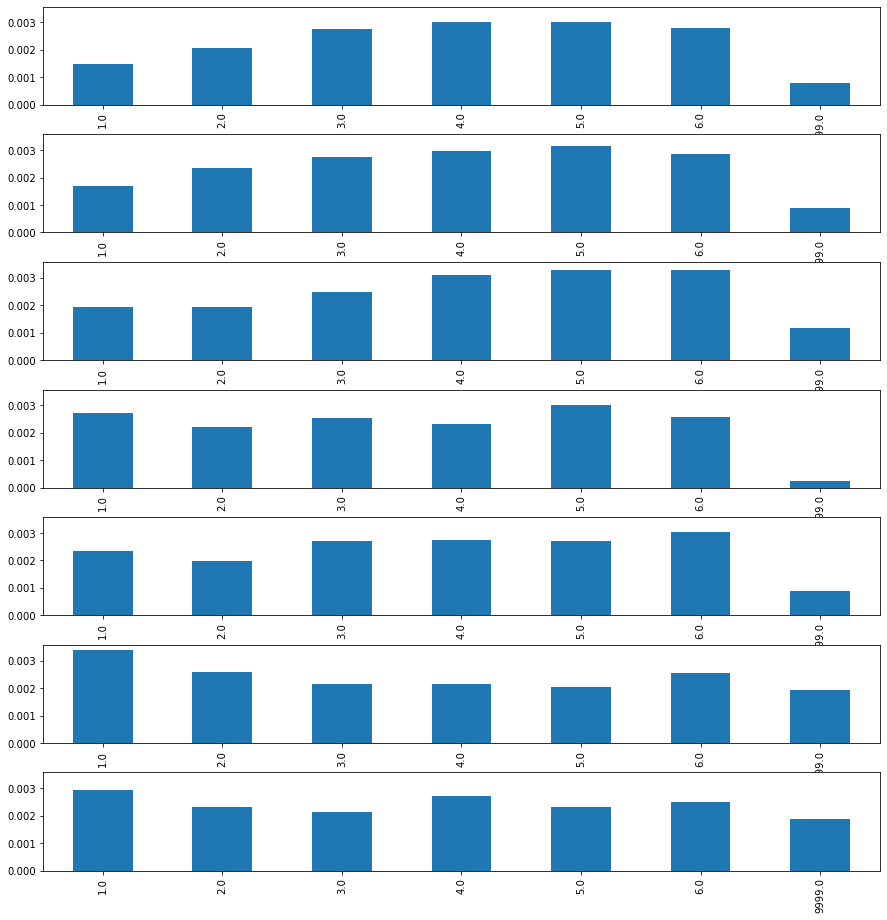

In [40]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15,8), sharey=True)
plt.subplots_adjust(top = 1.5, bottom=0.0, hspace=0.3)
i = 0
for k in gp1+gp2:
#     print(k)
    weekly_long_l1[k].loc[weeks_in].iloc[:,:].mean().plot.bar(ax=axes[i])
    i += 1

#### Insample sharp

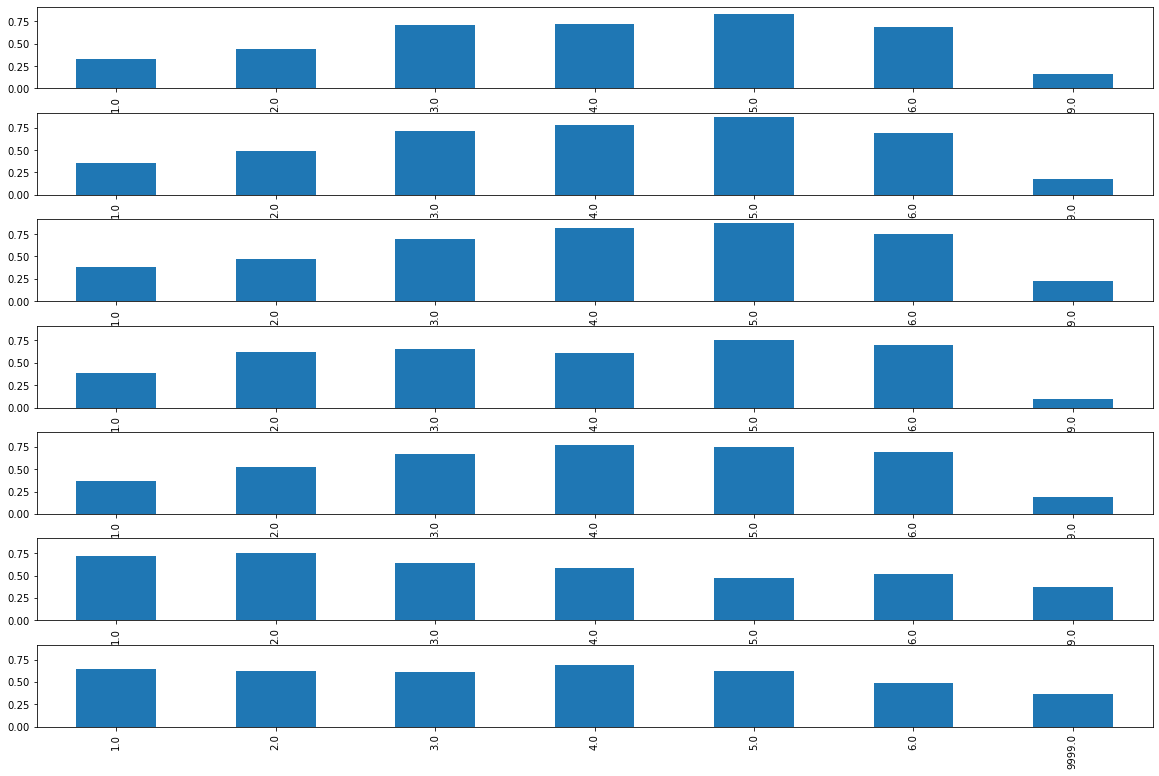

In [41]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,10), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)

i = 0
for k in gp1+gp2:
#     print(k)
    (longs_l1[k].loc[dates_in].mean()/longs_l1[k].loc[dates_in].std()*np.sqrt(252)).plot.bar(ax=axes[i])
    i += 1

#### select universe

In [42]:
long_universe = factor_models_l1['data_set_1']*np.nan
long_universe[
                (factor_models_l1['data_set_1']==5) |
                (factor_models_l1['data_set_2']==5) |
                (factor_models_l1['data_set_3']==5) |
#                 (factor_models_l1['data_set_4']==5) |
                (factor_models_l1['data_set_5']==6) |
                (factor_models_l1['data_set_6']==1) |
                (factor_models_l1['data_set_7']==1)
            ]=1
long_universe = long_universe * in_trading_universe

short_universe = factor_models_l1['data_set_1']*np.nan
short_universe[long_universe.isna()]=1
short_universe = short_universe * in_trading_universe


<AxesSubplot:xlabel='data_date'>

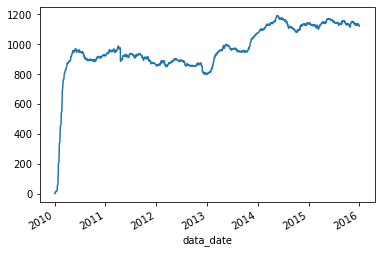

In [43]:
long_universe.loc[dates_in].sum(1).plot()

<AxesSubplot:xlabel='data_date'>

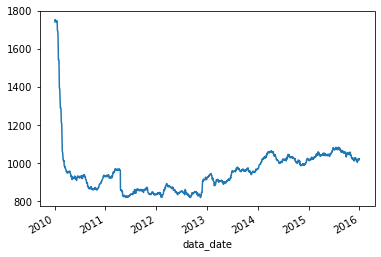

In [44]:
short_universe.loc[dates_in].sum(1).plot()

### layer 2  -- long

In [45]:
num_ranks3 = 20  
num_ranks4 = 15  

long_models_l2 = {}
risk_map = {'data_set_8': 'rf3',
            'data_set_9': 'rf3',
            'data_set_10': 'rf4',
            'data_set_11': 'rf4'}

In [46]:
importlib.reload(utilities)
for k in gp3+gp4: 
    factor = factors[k]*long_universe # apply layer 1
#     rf = risk_map[k]
#     factor = orthogonal(factor, risk_factors[rf]) # neutralize risk factors
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better
    if k in gp3:
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks3))
    else:
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks4))
    factor.fillna(9999, inplace=True) # not in factor
    factor = factor * in_trading_universe # select stock universe
#     factor.fillna(19999, inplace=True) # not tradable
    long_models_l2[k] = factor

In [47]:
num_ranks32 = 40 
num_ranks42 = 30 

In [48]:
for k in gp3+gp4: 
    factor = factors[k]
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better
    if k in gp3:
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks32))
    else:
        factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks42))
    factor.fillna(9999, inplace=True) # not in factor
    factor = factor * in_trading_universe # select stock universe
#     factor.fillna(19999, inplace=True) # not tradable
    long_models_l2[k+'_raw'] = factor

In [49]:
importlib.reload(utilities)

keys = list(long_models_l2.keys())
l = [long_models_l2[k] for k in keys]
nrows = len(keys)
para = zip(keys, l, [ret1d]*nrows, [cost_buy]*nrows, [cost_sell]*nrows)
with Pool() as p:
    res=p.starmap(utilities.quick_backtesting, para) # with trading cost
    
longs_l2 = {x['name']: x['long_pnl'] for x in res}
longs_counts_l2 = {x['name']: x['counts'] for x in res}
longs_turnovers_l2 = {x['name']: x['turnover'] for x in res}


#### long counts

data_set_8 1081.0 48.287049399198935
data_set_9 1135.0 45.19559412550067
data_set_10 1316.0 37.86448598130841
data_set_11 1316.0 37.86448598130841
data_set_8_raw 21.0 46.39761431411531
data_set_9_raw 168.0 43.81709741550696
data_set_10_raw 609.0 32.84691848906561
data_set_11_raw 609.0 32.84691848906561


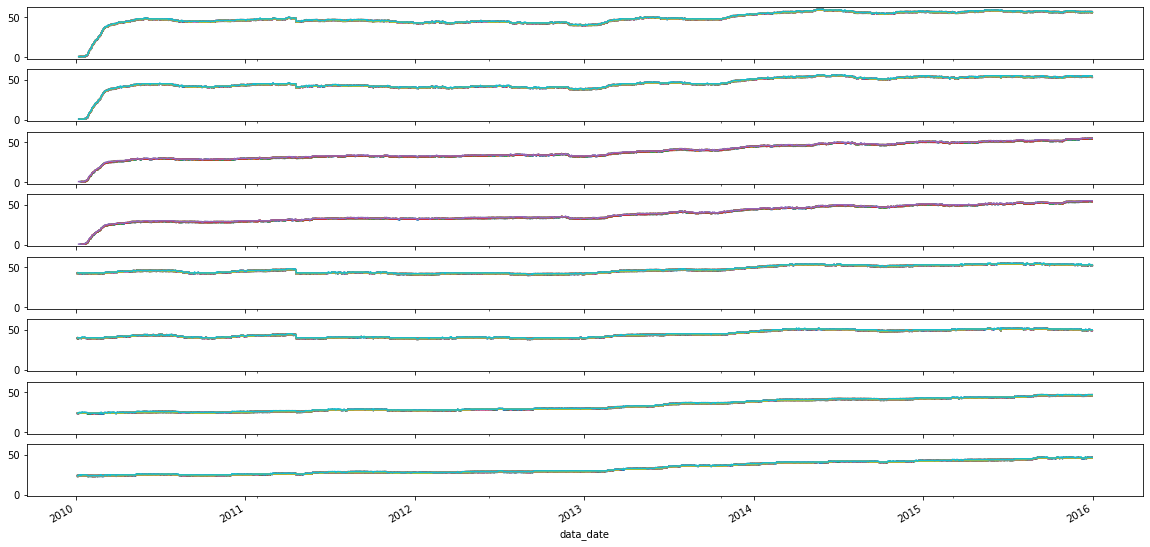

In [50]:
nrows = len(long_models_l2.keys())
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,10), sharex=True, sharey=True)
i = 0
for k in long_models_l2.keys():
    print(k, longs_counts_l2[k][9999][-1], longs_counts_l2[k][1][dates_in].mean())
    longs_counts_l2[k].loc[dates_in].iloc[:,:-1].plot(ax=axes[i], legend=False)
    i += 1

In [51]:
weekly_long_l2 = {}
weekly_long_turnover_l2 = {}
for k in long_models_l2.keys():
    weekly_long_l2[k] = longs_l2[k].groupby([longs_l2[k].index.year, 
                                       longs_l2[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')
    weekly_long_turnover_l2[k] = longs_turnovers_l2[k].groupby([longs_turnovers_l2[k].index.year, 
                                       longs_turnovers_l2[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')


#### long pnls -- mean

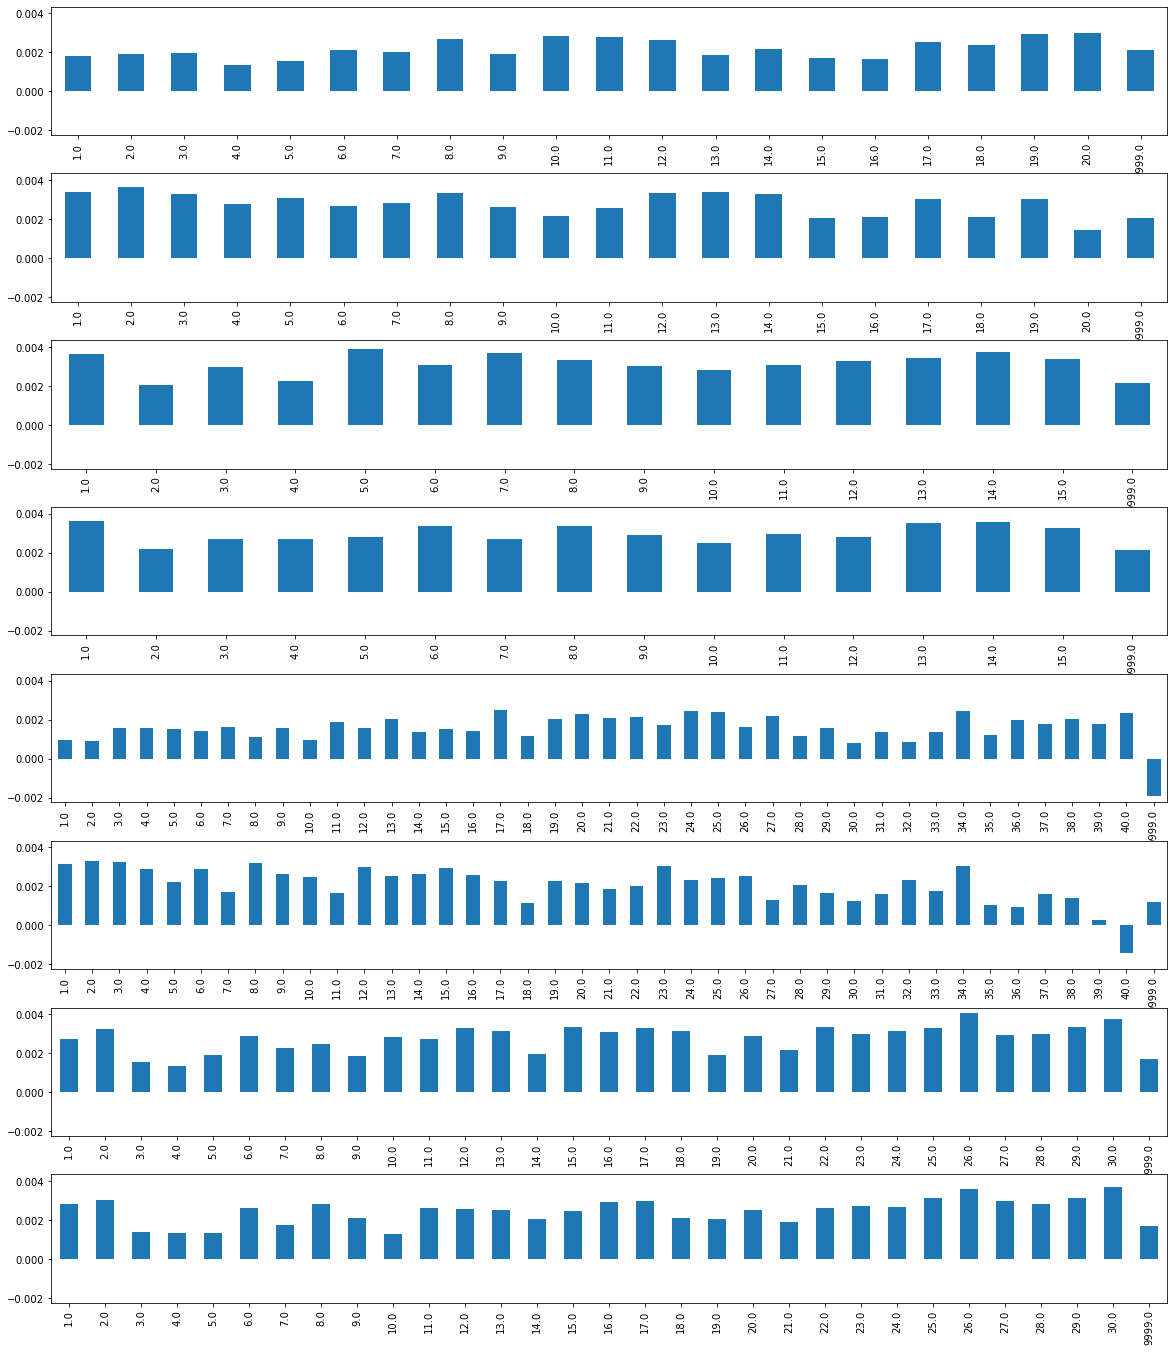

In [52]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,18), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)
i = 0
for k in long_models_l2.keys():
    weekly_long_l2[k].loc[weeks_in].mean().plot.bar(ax=axes[i])
    i += 1

#### long pnls -- sharp

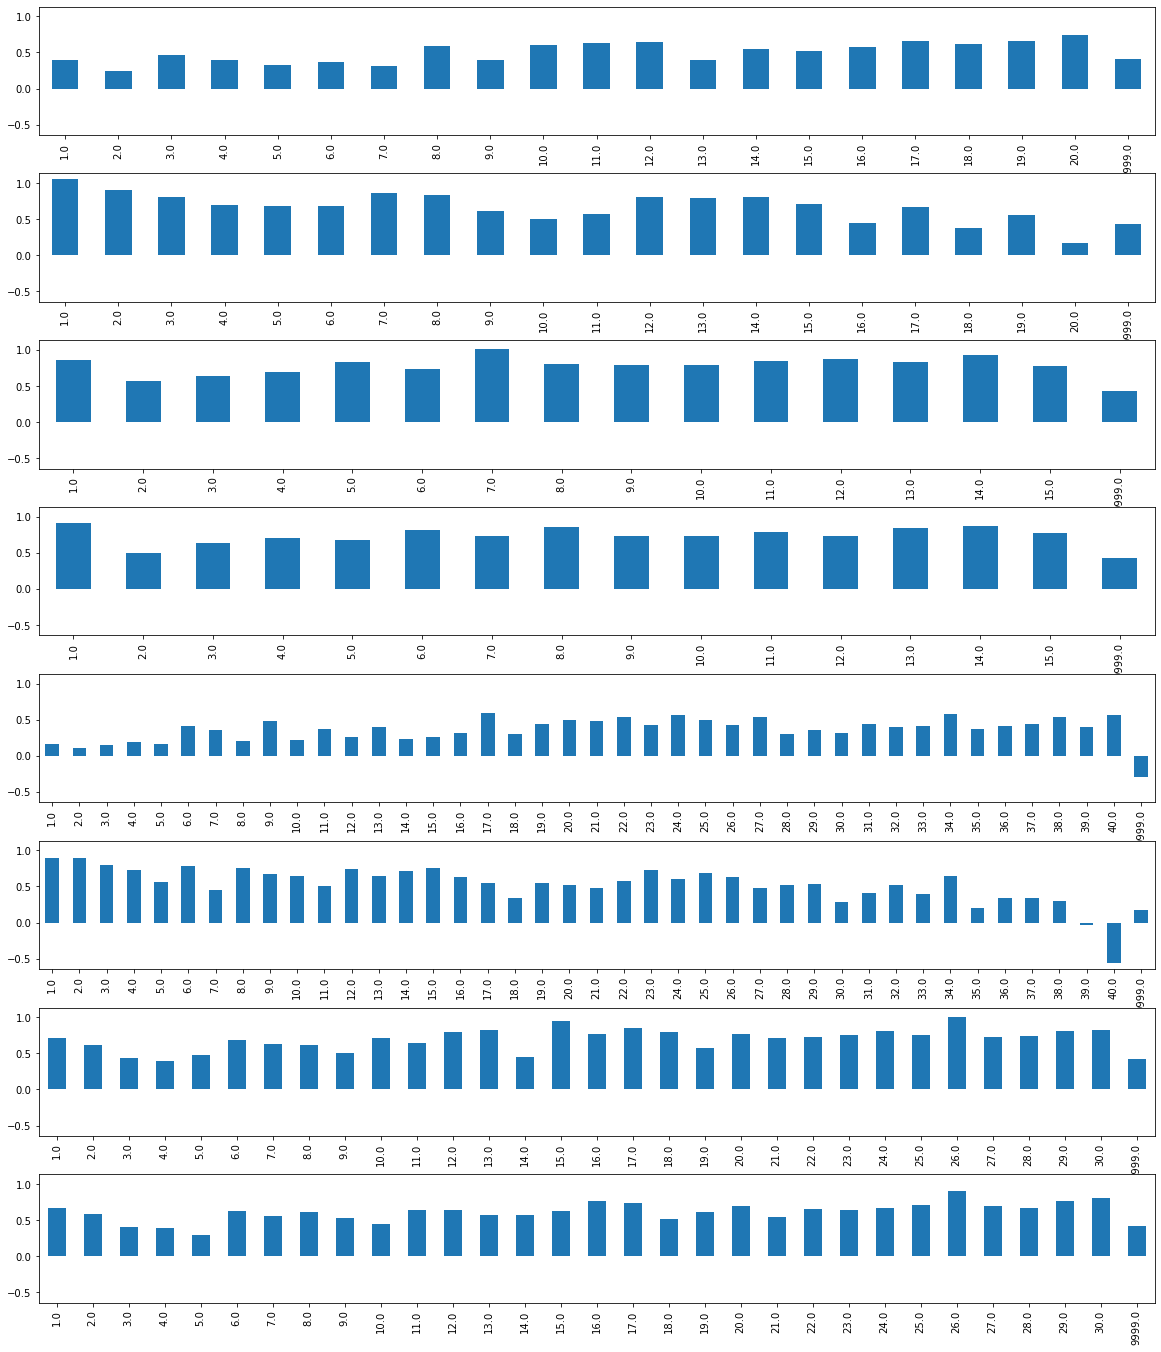

In [53]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,18), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)

i = 0
for k in long_models_l2.keys():
    (longs_l2[k].loc[dates_in].mean()/longs_l2[k].loc[dates_in].std()*np.sqrt(252)).plot.bar(ax=axes[i])
    i += 1

#### long turnovers

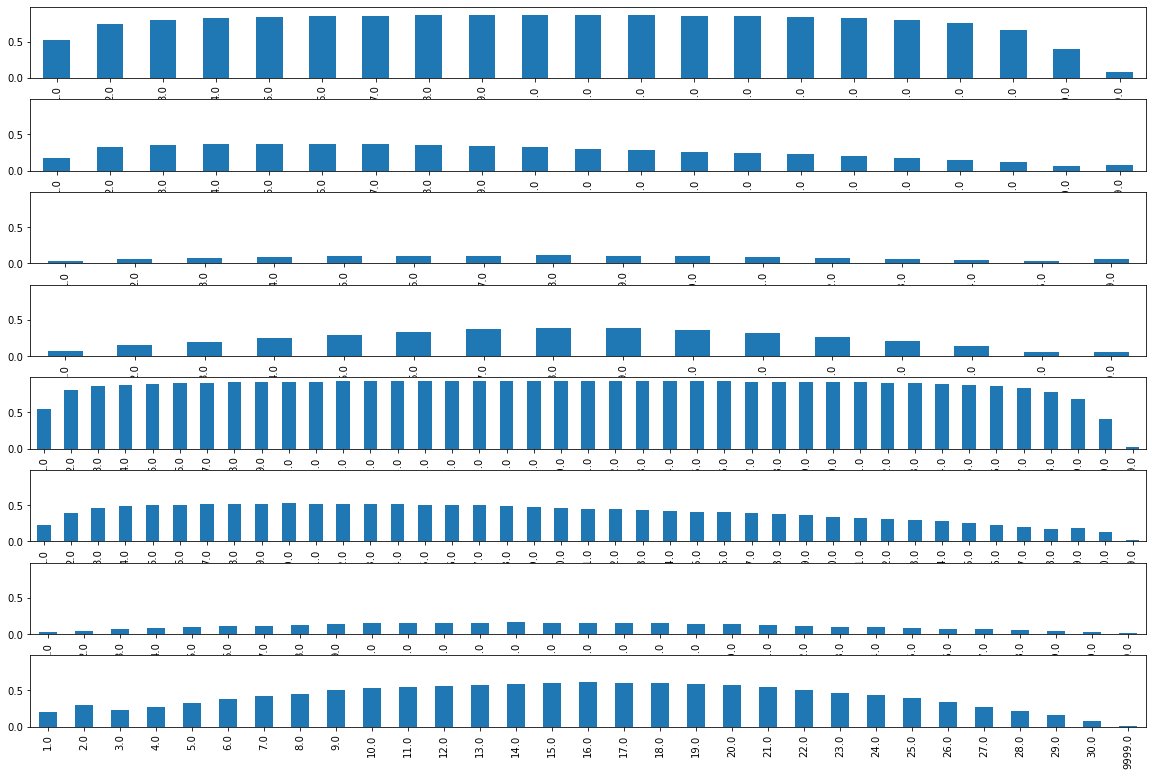

In [54]:
nrows = len(long_models_l2.keys())
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,10), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)
i=0
for k in long_models_l2.keys():
    longs_turnovers_l2[k].loc[dates_in].mean().plot.bar(ax=axes[i])
    i += 1

### layer 2 -- short

In [55]:
num_ranks3 = 20 # best
short_models_l2 = {}
# risk_map = {'data_set_8': 'rf5', 'data_set_9': 'rf5'}

In [56]:
importlib.reload(utilities)
for k in gp3: 
    factor = factors[k] * short_universe
#     rf = risk_map[k]
#     factor = utilities.orthogonal(factor, risk_factors[rf]) # neutralize risk factors
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better
    factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks3))
    factor.fillna(9999, inplace=True) # not in factor
    factor = factor * in_trading_universe # select stock universe
#     factor.fillna(19999, inplace=True) # not tradable
    short_models_l2[k] = factor

In [57]:
num_ranks31 = 40

In [58]:
for k in gp3: # short 9999 from raw factor
    factor = factors[k]
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better
    factor = np.ceil(factor.rank(axis=1, pct=True).mul(num_ranks31))
    factor.fillna(9999, inplace=True) # not in factor
    factor = factor * in_trading_universe # select stock universe
#     factor.fillna(19999, inplace=True) # not tradable
    short_models_l2[k+'_raw'] = factor

In [59]:
importlib.reload(utilities)
keys= list(short_models_l2.keys())
l = [short_models_l2[k] for k in keys]
nrows = len(keys)
para = zip(keys, l, [ret1d]*nrows, [cost_buy]*nrows, [cost_sell]*nrows)
with Pool() as p:
    res=p.starmap(utilities.quick_backtesting, para) # 0 trading cost
    
shorts_l2 = {x['name']: x['short_pnl'] for x in res}
shorts_counts_l2 = {x['name']: x['counts'] for x in res}
shorts_turnovers_l2 = {x['name']: x['turnover'] for x in res}

#### short counts

data_set_8 1219.0 44.909211398277
data_set_9 1312.0 42.83101391650099
data_set_8_raw 21.0 46.39761431411531
data_set_9_raw 168.0 43.81709741550696


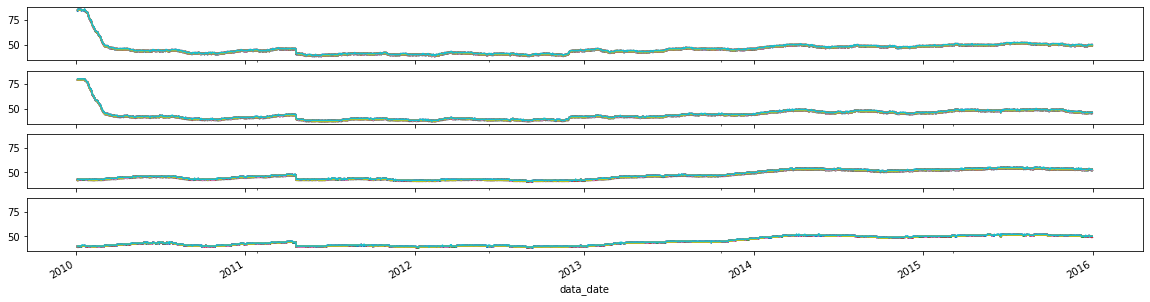

In [60]:
nrows = len(short_models_l2.keys())
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,5), sharex=True, sharey=True)
i = 0
for k in short_models_l2.keys():
    print(k, shorts_counts_l2[k][9999][-1], shorts_counts_l2[k][1][dates_in].mean())
    shorts_counts_l2[k].loc[dates_in].iloc[:,:-1].plot(ax=axes[i], legend=False)
    i += 1

In [61]:
weekly_short_l2 = {}
weekly_short_turnover_l2 = {}
for k in short_models_l2.keys():
    weekly_short_l2[k] = shorts_l2[k].groupby([shorts_l2[k].index.year, 
                                       shorts_l2[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')
    weekly_short_turnover_l2[k] = shorts_turnovers_l2[k].groupby([shorts_turnovers_l2[k].index.year, 
                                       shorts_turnovers_l2[k].index.isocalendar().week]).transform('sum').drop_duplicates(keep='last')


#### short pnls -- mean

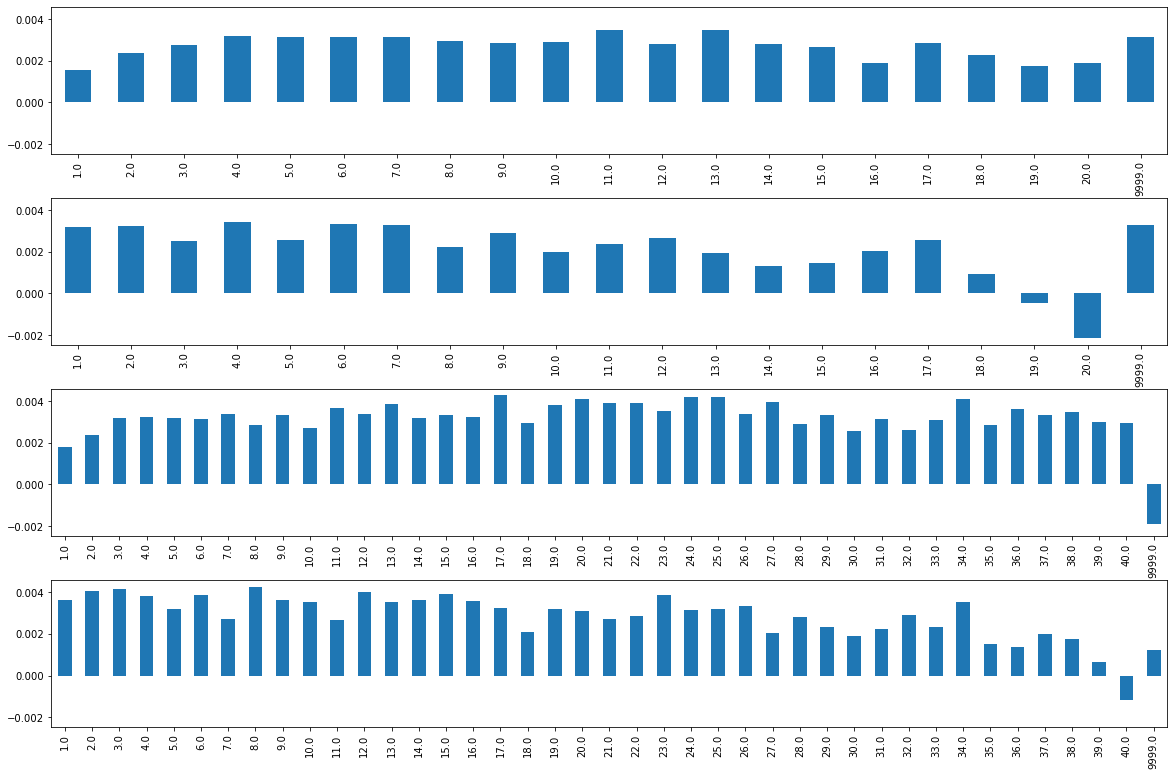

In [62]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,10), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)
i = 0
for k in short_models_l2.keys():
    weekly_short_l2[k].loc[weeks_in].mean().plot.bar(ax=axes[i])
    i += 1

#### short pnls -- sharp

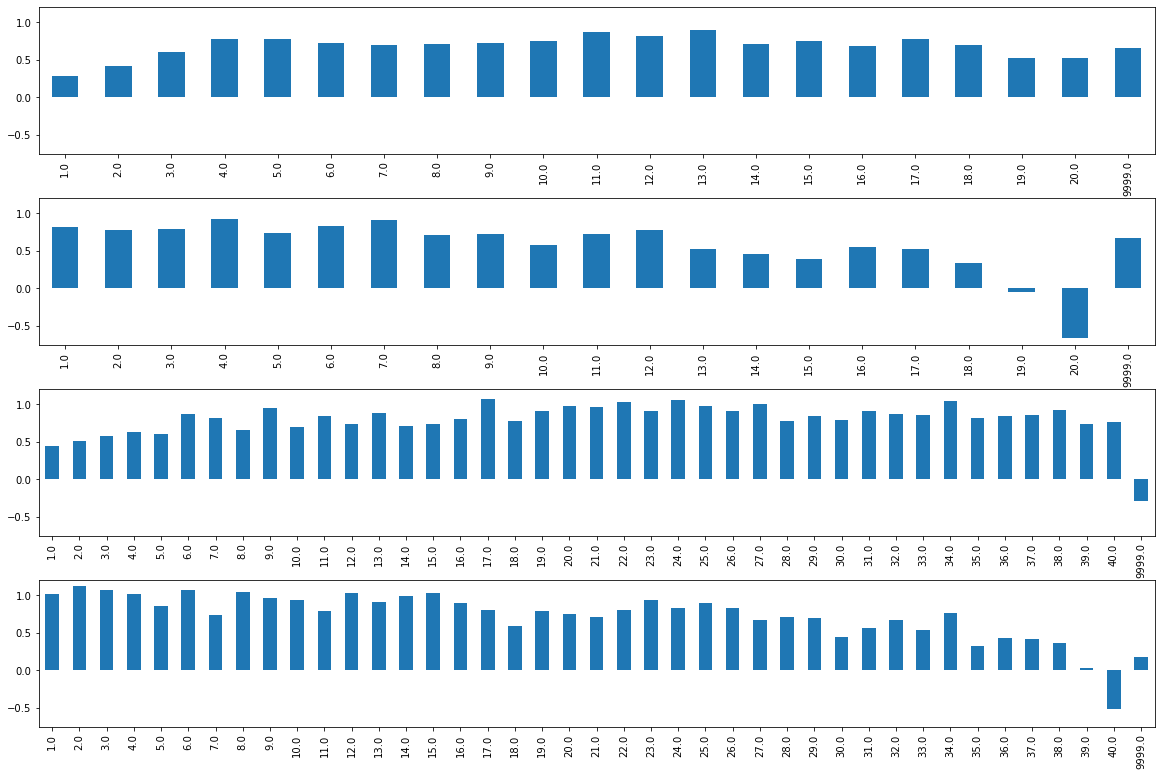

In [63]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,10), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)

i = 0
for k in short_models_l2.keys():
    (shorts_l2[k].loc[dates_in].mean()/shorts_l2[k].loc[dates_in].std()*np.sqrt(252)).plot.bar(ax=axes[i])
    i += 1

#### short turnovers

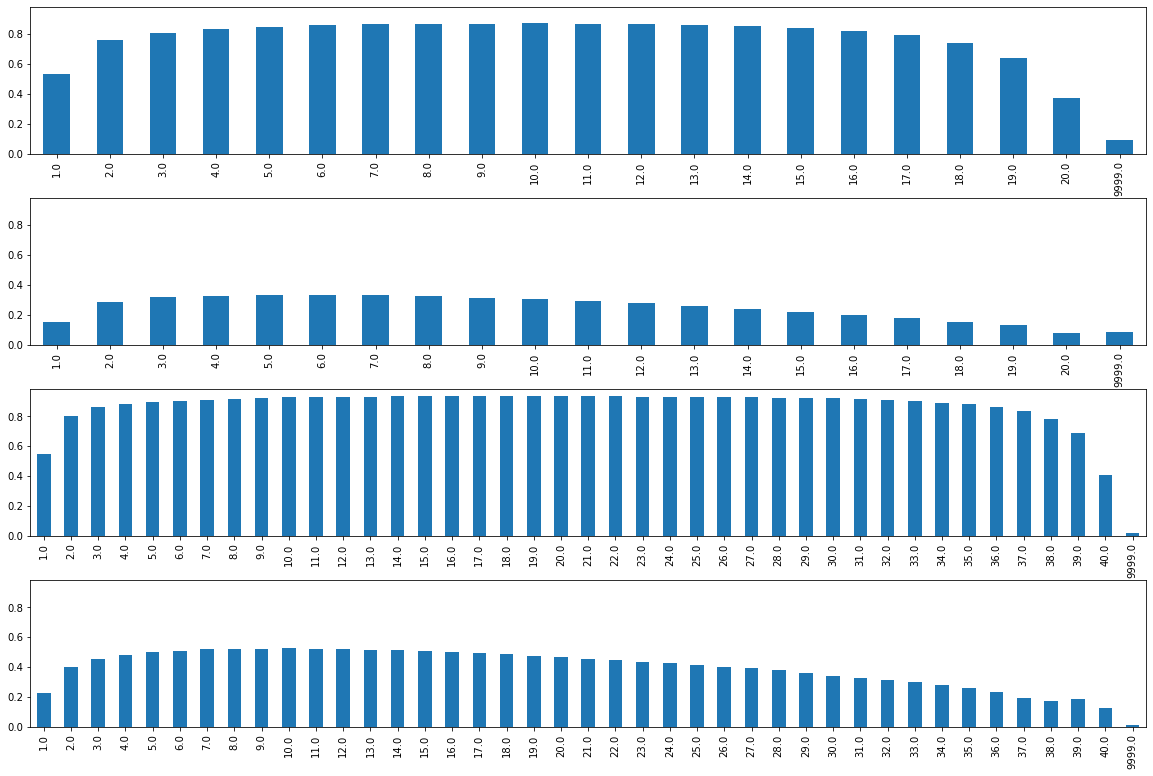

In [64]:
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20,10), sharey=True)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=0.3)
i=0
for k in short_models_l2.keys():
    shorts_turnovers_l2[k].loc[dates_in].mean().plot.bar(ax=axes[i])
    i += 1

### select long-short models

Finally we select four models two long and two short) with good performance to build our model. For simplicity, we weighted these four models equally. The result is given below.

In [65]:
long_leg = {}
long_leg['L1'] = longs_l2['data_set_10'][1]
long_leg['L2'] = longs_l2['data_set_11'][1]

short_leg = {}
short_leg['S1'] = shorts_l2['data_set_8_raw'][9999]
short_leg['S2'] = shorts_l2['data_set_9'][20]

<AxesSubplot:>

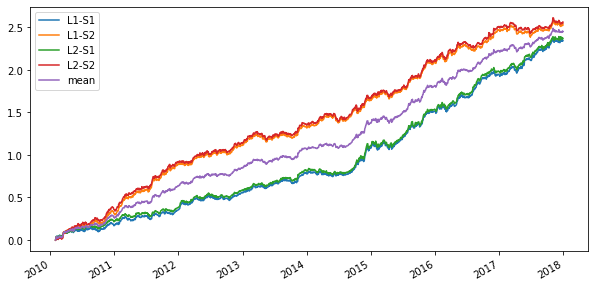

In [66]:
pnls = pd.DataFrame()
for k1 in long_leg.keys():
    for k2 in short_leg.keys():
        k = str(k1)+'-'+str(k2)
        pnls[k] = (long_leg[k1]-short_leg[k2])
        
pnls['mean']=pnls.mean(1)
pnls[pnls.index>'2010-02-01'].cumsum().plot(legend=True, figsize=(10,5))

## Backtesting whole portfolio

In [67]:
importlib.reload(utilities)

config = {
    'target': 0.5,
    'net': 0.00, # min threshold of portfolio position
    'weighting_method': 'EW', #'MVO', #'EW',
    'backtesting_method': 'vanilla', #'turnover', #'vanilla', #'turnover',
    'begin_date': '2010-01-01',
    'end_date': '2018-01-01',
    'max_turnover': 0.005, # only used in 'turnover'
    'longshort': 'long', # only used in MVO
    
    'trading_cost': (-cost_buy, -cost_sell),
    'num_stks': 100, # no use
    'gamma': 0.001, # only used in MVO since the goal of MVO is to reduce volatility and drawdown, set small gamma
    'ret_c2c': ret1d,
    'industry': industry  # only used in MVO, to control weights among each industry
}

In [68]:
models = {
    'data_set_10': factors['data_set_10']*long_universe, # apply layer 1
    'data_set_11': factors['data_set_11']*long_universe, # apply layer 1
    '-data_set_9': -factors['data_set_9']*short_universe, # apply layer 1
    '-data_set_8': factors['data_set_8'] # do not apply layer 1
         }

In [69]:
num_ranks3 = 20  # 
num_ranks4 = 15  # 


rank_map = {'data_set_9': num_ranks3,
            'data_set_10': num_ranks4,
            'data_set_11': num_ranks4,
            '-data_set_11': num_ranks4,
            '-data_set_8': num_ranks3*2,
            '-data_set_9': num_ranks3}
select = {'data_set_9': 1,
            'data_set_10': 1,
            'data_set_11': 1,
          '-data_set_11': 1,
           '-data_set_8': 9999,
           '-data_set_9': 1}

In [70]:
config_list = []
keys = list(models.keys())
print(keys)
for k in keys:
    factor = models[k].copy()
    factor = factor.rank(1, ascending=True, method='first') # desensitize factor via ranking operation, lower rank is better

    
    factor_gp = np.ceil(factor.rank(axis=1, pct=True).mul(rank_map[k]))
    factor_gp = factor_gp.fillna(9999)* in_trading_universe # select stock universe
    factor_gp_counts = factor_gp.apply(pd.Series.value_counts, axis=1)
    config['num_stks'] = factor_gp_counts[select[k]] 
    factor.fillna(9999, inplace=True)
    factor = factor * in_trading_universe # select stock universe
    factor.fillna(19999, inplace=True) # not tradable

    config['factor'] = factor
    if k=='-data_set_8': 
        factor[factor<9999]=9998
        factor[factor==9999]=1
        config['factor'] = factor
    config_list.append(config.copy())

['data_set_10', 'data_set_11', '-data_set_9', '-data_set_8']


In [71]:
importlib.reload(utilities)
pos_list = utilities.batch_backtesting(config_list)

/Users/tbian/Google Drive/Applications/Industry/2021/Cubist/utilities.py:52: RuntimeWarning: invalid value encountered in true_divide
  portfolio = portfolio/portfolio.sum(axis=1).reshape(-1,1) # in case num_stks > # of stks
/Users/tbian/Google Drive/Applications/Industry/2021/Cubist/utilities.py:52: RuntimeWarning: invalid value encountered in true_divide
  portfolio = portfolio/portfolio.sum(axis=1).reshape(-1,1) # in case num_stks > # of stks
/Users/tbian/Google Drive/Applications/Industry/2021/Cubist/utilities.py:52: RuntimeWarning: invalid value encountered in true_divide
  portfolio = portfolio/portfolio.sum(axis=1).reshape(-1,1) # in case num_stks > # of stks


In [72]:
importlib.reload(utilities)
positions = pos_list[0] + pos_list[1] - pos_list[2] - pos_list[3]
data = utilities.pnl_calculation(positions, **config)
res = utilities.summarize(positions=positions, **data)

In [73]:
pd.DataFrame(res['summary'], index=['all'])

,sharpe,sharpe_cost,sortino,sortino_cost,pnl,pnl_cost,volatility,volatility_cost,pos_days,pos_days_cost
all,2.970892,2.921986,4.738831,4.65958,0.326355,0.320998,0.109178,0.109172,0.586687,0.586687


In [74]:
res['yearly_stats']

,sharpe,sharpe_cost,sortino,sortino_cost,pnl,pnl_cost,volatility,volatility_cost,pos_days,pos_days_cost
data_date,,,,,,,,,,
2010,2.839873,2.783407,5.273227,5.153001,0.303743,0.297617,0.106252,0.106207,0.579365,0.579365
2011,4.308907,4.254465,7.454608,7.360199,0.410726,0.405551,0.094856,0.094853,0.607143,0.607143
2012,2.320390,2.262657,3.297650,3.215063,0.205160,0.200111,0.087554,0.087557,0.580000,0.580000
2013,2.386734,2.334757,4.668421,4.565583,0.233050,0.228013,0.096806,0.096804,0.539683,0.539683
2014,3.074348,3.030376,4.550455,4.485163,0.346863,0.341938,0.112174,0.112177,0.615079,0.615079
2015,3.500512,3.461190,5.371074,5.310705,0.473001,0.467726,0.134552,0.134557,0.634921,0.634921
2016,3.479294,3.426774,5.648549,5.562491,0.399575,0.393579,0.114269,0.114271,0.591270,0.591270
2017,1.966238,1.922354,3.073093,3.003931,0.237406,0.232135,0.119724,0.119715,0.545817,0.545817


<AxesSubplot:xlabel='data_date'>

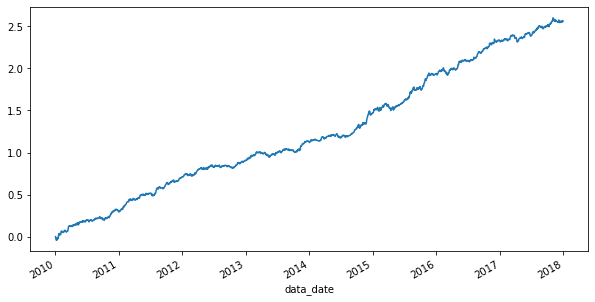

In [75]:
res['nav_cost'].plot(figsize=(10,5))

<AxesSubplot:xlabel='data_date'>

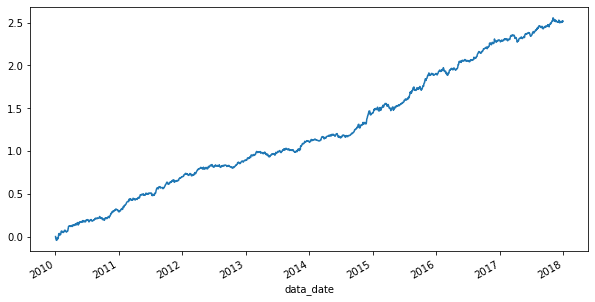

In [76]:
res['nav_cost_geo'].plot(figsize=(10,5))

<AxesSubplot:xlabel='data_date'>

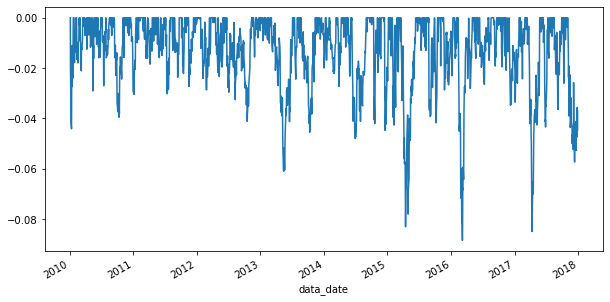

In [77]:
res['drawdown_cost'].plot(figsize=(10,5))

<AxesSubplot:xlabel='data_date'>

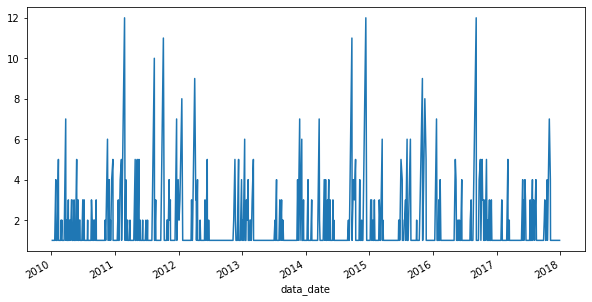

In [78]:
res['drawdown_cost_period'].plot(figsize=(10,5))

<AxesSubplot:xlabel='data_date'>

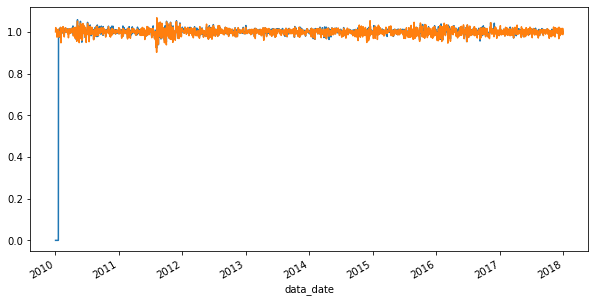

In [79]:
res['pos_long'].plot(figsize=(10,5))
res['pos_short'].plot(figsize=(10,5))

<AxesSubplot:xlabel='data_date'>

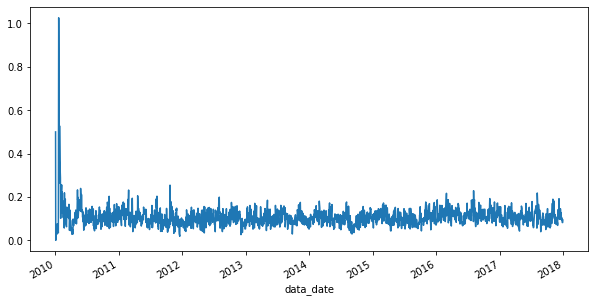

In [80]:
res['turnover'].plot(figsize=(10,5))